In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 829)
(663976, 1)
validation
(128936, 829)
(128936, 1)
test
(61376, 829)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:43 - loss: 0.0745 - STD: 1.4051e-04 - MAE: 0.2542

 4/67 [>.............................] - ETA: 1s - loss: 0.0324 - STD: 3.6102e-04 - MAE: 0.1408  

 5/67 [=>............................] - ETA: 2s - loss: 0.0317 - STD: 3.3085e-04 - MAE: 0.1399

 6/67 [=>............................] - ETA: 2s - loss: 0.0316 - STD: 3.0327e-04 - MAE: 0.1400

 7/67 [==>...........................] - ETA: 2s - loss: 0.0313 - STD: 2.7952e-04 - MAE: 0.1398

 8/67 [==>...........................] - ETA: 2s - loss: 0.0309 - STD: 2.5929e-04 - MAE: 0.1388

 9/67 [===>..........................] - ETA: 2s - loss: 0.0302 - STD: 2.4261e-04 - MAE: 0.1369

10/67 [===>..........................] - ETA: 2s - loss: 0.0294 - STD: 2.2890e-04 - MAE: 0.1345

11/67 [===>..........................] - ETA: 2s - loss: 0.0285 - STD: 2.1786e-04 - MAE: 0.1314

12/67 [====>.........................] - ETA: 2s - loss: 0.0274 - STD: 2.0907e-04 - MAE: 0.1278

13/67 [====>.........................] - ETA: 2s - loss: 0.0262 - STD: 2.0221e-04 - MAE: 0.1242

14/67 [=====>........................] - ETA: 2s - loss: 0.0252 - STD: 1.9676e-04 - MAE: 0.1215

15/67 [=====>........................] - ETA: 2s - loss: 0.0243 - STD: 1.9240e-04 - MAE: 0.1194

16/67 [======>.......................] - ETA: 2s - loss: 0.0237 - STD: 1.8878e-04 - MAE: 0.1182

17/67 [======>.......................] - ETA: 2s - loss: 0.0232 - STD: 1.8584e-04 - MAE: 0.1176

18/67 [=======>......................] - ETA: 2s - loss: 0.0228 - STD: 1.8336e-04 - MAE: 0.1172

19/67 [=======>......................] - ETA: 2s - loss: 0.0224 - STD: 1.8140e-04 - MAE: 0.1167

20/67 [=======>......................] - ETA: 2s - loss: 0.0220 - STD: 1.7990e-04 - MAE: 0.1160

21/67 [========>.....................] - ETA: 2s - loss: 0.0216 - STD: 1.7881e-04 - MAE: 0.1150

22/67 [========>.....................] - ETA: 2s - loss: 0.0211 - STD: 1.7796e-04 - MAE: 0.1137

23/67 [=========>....................] - ETA: 2s - loss: 0.0207 - STD: 1.7730e-04 - MAE: 0.1125

24/67 [=========>....................] - ETA: 2s - loss: 0.0203 - STD: 1.7678e-04 - MAE: 0.1112

25/67 [==========>...................] - ETA: 2s - loss: 0.0200 - STD: 1.7631e-04 - MAE: 0.1100

26/67 [==========>...................] - ETA: 2s - loss: 0.0197 - STD: 1.7588e-04 - MAE: 0.1090

27/67 [===========>..................] - ETA: 2s - loss: 0.0194 - STD: 1.7560e-04 - MAE: 0.1080

28/67 [===========>..................] - ETA: 2s - loss: 0.0192 - STD: 1.7545e-04 - MAE: 0.1071

29/67 [===========>..................] - ETA: 2s - loss: 0.0190 - STD: 1.7546e-04 - MAE: 0.1063

30/67 [============>.................] - ETA: 2s - loss: 0.0188 - STD: 1.7573e-04 - MAE: 0.1055

31/67 [============>.................] - ETA: 2s - loss: 0.0186 - STD: 1.7610e-04 - MAE: 0.1047

32/67 [=============>................] - ETA: 2s - loss: 0.0184 - STD: 1.7677e-04 - MAE: 0.1040

33/67 [=============>................] - ETA: 2s - loss: 0.0182 - STD: 1.7759e-04 - MAE: 0.1033

34/67 [==============>...............] - ETA: 1s - loss: 0.0180 - STD: 1.7868e-04 - MAE: 0.1027

35/67 [==============>...............] - ETA: 1s - loss: 0.0178 - STD: 1.7994e-04 - MAE: 0.1022

36/67 [===============>..............] - ETA: 1s - loss: 0.0176 - STD: 1.8134e-04 - MAE: 0.1017

37/67 [===============>..............] - ETA: 1s - loss: 0.0174 - STD: 1.8284e-04 - MAE: 0.1013

38/67 [================>.............] - ETA: 1s - loss: 0.0173 - STD: 1.8446e-04 - MAE: 0.1010

39/67 [================>.............] - ETA: 1s - loss: 0.0171 - STD: 1.8626e-04 - MAE: 0.1007

40/67 [================>.............] - ETA: 1s - loss: 0.0170 - STD: 1.8808e-04 - MAE: 0.1004

41/67 [=================>............] - ETA: 1s - loss: 0.0169 - STD: 1.8992e-04 - MAE: 0.1001

42/67 [=================>............] - ETA: 1s - loss: 0.0167 - STD: 1.9174e-04 - MAE: 0.0998

43/67 [==================>...........] - ETA: 1s - loss: 0.0166 - STD: 1.9366e-04 - MAE: 0.0995

44/67 [==================>...........] - ETA: 1s - loss: 0.0165 - STD: 1.9553e-04 - MAE: 0.0991

45/67 [===================>..........] - ETA: 1s - loss: 0.0164 - STD: 1.9741e-04 - MAE: 0.0988

46/67 [===================>..........] - ETA: 1s - loss: 0.0164 - STD: 1.9927e-04 - MAE: 0.0984

49/67 [====================>.........] - ETA: 1s - loss: 0.0161 - STD: 2.0530e-04 - MAE: 0.0975

51/67 [=====================>........] - ETA: 1s - loss: 0.0159 - STD: 2.0979e-04 - MAE: 0.0969

52/67 [======================>.......] - ETA: 1s - loss: 0.0158 - STD: 2.1222e-04 - MAE: 0.0966

53/67 [======================>.......] - ETA: 0s - loss: 0.0157 - STD: 2.1482e-04 - MAE: 0.0964

54/67 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 2.1749e-04 - MAE: 0.0962

55/67 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 2.2038e-04 - MAE: 0.0960

56/67 [========================>.....] - ETA: 0s - loss: 0.0155 - STD: 2.2332e-04 - MAE: 0.0958

57/67 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 2.2643e-04 - MAE: 0.0956

58/67 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 2.2956e-04 - MAE: 0.0954

59/67 [=========================>....] - ETA: 0s - loss: 0.0153 - STD: 2.3282e-04 - MAE: 0.0953

60/67 [=========================>....] - ETA: 0s - loss: 0.0152 - STD: 2.3619e-04 - MAE: 0.0951

61/67 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 2.3956e-04 - MAE: 0.0950

62/67 [==========================>...] - ETA: 0s - loss: 0.0151 - STD: 2.4309e-04 - MAE: 0.0948

63/67 [===========================>..] - ETA: 0s - loss: 0.0150 - STD: 2.4655e-04 - MAE: 0.0946

64/67 [===========================>..] - ETA: 0s - loss: 0.0150 - STD: 2.5016e-04 - MAE: 0.0944

65/67 [============================>.] - ETA: 0s - loss: 0.0149 - STD: 2.5383e-04 - MAE: 0.0942

66/67 [============================>.] - ETA: 0s - loss: 0.0149 - STD: 2.5754e-04 - MAE: 0.0941

67/67 [==============================] - ETA: 0s - loss: 0.0148 - STD: 2.6144e-04 - MAE: 0.0939

67/67 [==============================] - 7s 81ms/step - loss: 0.0148 - STD: 2.6144e-04 - MAE: 0.0939 - val_loss: 0.0102 - val_STD: 3.7342e-04 - val_MAE: 0.0800


Epoch 2/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0114 - STD: 5.3119e-04 - MAE: 0.0827

 2/67 [..............................] - ETA: 4s - loss: 0.0115 - STD: 5.4227e-04 - MAE: 0.0832

 3/67 [>.............................] - ETA: 4s - loss: 0.0115 - STD: 5.5088e-04 - MAE: 0.0832

 4/67 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 5.6191e-04 - MAE: 0.0833

 5/67 [=>............................] - ETA: 4s - loss: 0.0114 - STD: 5.7241e-04 - MAE: 0.0834

 6/67 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 5.8308e-04 - MAE: 0.0835

 7/67 [==>...........................] - ETA: 3s - loss: 0.0114 - STD: 5.9428e-04 - MAE: 0.0837

 8/67 [==>...........................] - ETA: 3s - loss: 0.0114 - STD: 6.0465e-04 - MAE: 0.0839

 9/67 [===>..........................] - ETA: 3s - loss: 0.0113 - STD: 6.1498e-04 - MAE: 0.0838

10/67 [===>..........................] - ETA: 3s - loss: 0.0113 - STD: 6.2558e-04 - MAE: 0.0838

11/67 [===>..........................] - ETA: 3s - loss: 0.0113 - STD: 6.3593e-04 - MAE: 0.0839

12/67 [====>.........................] - ETA: 3s - loss: 0.0113 - STD: 6.4668e-04 - MAE: 0.0838

13/67 [====>.........................] - ETA: 3s - loss: 0.0114 - STD: 6.5771e-04 - MAE: 0.0839

14/67 [=====>........................] - ETA: 3s - loss: 0.0114 - STD: 6.6892e-04 - MAE: 0.0839

15/67 [=====>........................] - ETA: 3s - loss: 0.0114 - STD: 6.8053e-04 - MAE: 0.0839

16/67 [======>.......................] - ETA: 3s - loss: 0.0114 - STD: 6.9231e-04 - MAE: 0.0838

17/67 [======>.......................] - ETA: 3s - loss: 0.0114 - STD: 7.0513e-04 - MAE: 0.0838

18/67 [=======>......................] - ETA: 3s - loss: 0.0114 - STD: 7.1806e-04 - MAE: 0.0838

19/67 [=======>......................] - ETA: 3s - loss: 0.0114 - STD: 7.3172e-04 - MAE: 0.0838

20/67 [=======>......................] - ETA: 2s - loss: 0.0114 - STD: 7.4618e-04 - MAE: 0.0839

21/67 [========>.....................] - ETA: 2s - loss: 0.0114 - STD: 7.6091e-04 - MAE: 0.0839

22/67 [========>.....................] - ETA: 2s - loss: 0.0114 - STD: 7.7603e-04 - MAE: 0.0839

23/67 [=========>....................] - ETA: 2s - loss: 0.0114 - STD: 7.9166e-04 - MAE: 0.0839

24/67 [=========>....................] - ETA: 2s - loss: 0.0114 - STD: 8.0793e-04 - MAE: 0.0839

25/67 [==========>...................] - ETA: 2s - loss: 0.0114 - STD: 8.2451e-04 - MAE: 0.0839

26/67 [==========>...................] - ETA: 2s - loss: 0.0114 - STD: 8.4229e-04 - MAE: 0.0839

27/67 [===========>..................] - ETA: 2s - loss: 0.0114 - STD: 8.5982e-04 - MAE: 0.0838

28/67 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 8.7811e-04 - MAE: 0.0838

29/67 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 8.9666e-04 - MAE: 0.0837

30/67 [============>.................] - ETA: 2s - loss: 0.0113 - STD: 9.1658e-04 - MAE: 0.0837

31/67 [============>.................] - ETA: 2s - loss: 0.0113 - STD: 9.3620e-04 - MAE: 0.0837

32/67 [=============>................] - ETA: 2s - loss: 0.0113 - STD: 9.5737e-04 - MAE: 0.0837

33/67 [=============>................] - ETA: 2s - loss: 0.0113 - STD: 9.7919e-04 - MAE: 0.0836

34/67 [==============>...............] - ETA: 2s - loss: 0.0113 - STD: 0.0010 - MAE: 0.0837    

35/67 [==============>...............] - ETA: 2s - loss: 0.0113 - STD: 0.0010 - MAE: 0.0837

36/67 [===============>..............] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0837

37/67 [===============>..............] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0836

38/67 [================>.............] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0837

39/67 [================>.............] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0837

40/67 [================>.............] - ETA: 1s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0837

41/67 [=================>............] - ETA: 1s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0837

42/67 [=================>............] - ETA: 1s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0837

43/67 [==================>...........] - ETA: 1s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0836

44/67 [==================>...........] - ETA: 1s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0836

45/67 [===================>..........] - ETA: 1s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0836

46/67 [===================>..........] - ETA: 1s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0836

47/67 [====================>.........] - ETA: 1s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0835

48/67 [====================>.........] - ETA: 1s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0835

49/67 [====================>.........] - ETA: 1s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0835

50/67 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0835

51/67 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0835

52/67 [======================>.......] - ETA: 0s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0835

53/67 [======================>.......] - ETA: 0s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0835

54/67 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0835

55/67 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0835

56/67 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 0.0019 - MAE: 0.0835

57/67 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 0.0020 - MAE: 0.0835

58/67 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 0.0020 - MAE: 0.0835

59/67 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0021 - MAE: 0.0834

60/67 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0022 - MAE: 0.0834

61/67 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 0.0023 - MAE: 0.0834

63/67 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0025 - MAE: 0.0833

64/67 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0026 - MAE: 0.0833

65/67 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0027 - MAE: 0.0833

66/67 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0028 - MAE: 0.0832

67/67 [==============================] - ETA: 0s - loss: 0.0112 - STD: 0.0029 - MAE: 0.0832

67/67 [==============================] - 5s 68ms/step - loss: 0.0112 - STD: 0.0029 - MAE: 0.0832 - val_loss: 0.0094 - val_STD: 0.0086 - val_MAE: 0.0781


Epoch 3/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0107 - STD: 0.0122 - MAE: 0.0820

 2/67 [..............................] - ETA: 4s - loss: 0.0106 - STD: 0.0126 - MAE: 0.0815

 3/67 [>.............................] - ETA: 4s - loss: 0.0106 - STD: 0.0130 - MAE: 0.0813

 4/67 [>.............................] - ETA: 4s - loss: 0.0105 - STD: 0.0135 - MAE: 0.0811

 5/67 [=>............................] - ETA: 4s - loss: 0.0105 - STD: 0.0140 - MAE: 0.0809

 6/67 [=>............................] - ETA: 3s - loss: 0.0104 - STD: 0.0145 - MAE: 0.0806

 7/67 [==>...........................] - ETA: 3s - loss: 0.0104 - STD: 0.0150 - MAE: 0.0805

 8/67 [==>...........................] - ETA: 3s - loss: 0.0103 - STD: 0.0155 - MAE: 0.0803

 9/67 [===>..........................] - ETA: 3s - loss: 0.0103 - STD: 0.0161 - MAE: 0.0801

10/67 [===>..........................] - ETA: 3s - loss: 0.0102 - STD: 0.0167 - MAE: 0.0799

11/67 [===>..........................] - ETA: 3s - loss: 0.0102 - STD: 0.0173 - MAE: 0.0798

12/67 [====>.........................] - ETA: 3s - loss: 0.0102 - STD: 0.0179 - MAE: 0.0796

13/67 [====>.........................] - ETA: 3s - loss: 0.0101 - STD: 0.0185 - MAE: 0.0795

14/67 [=====>........................] - ETA: 3s - loss: 0.0101 - STD: 0.0192 - MAE: 0.0794

15/67 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 0.0198 - MAE: 0.0792

16/67 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 0.0205 - MAE: 0.0791

17/67 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 0.0212 - MAE: 0.0790

18/67 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 0.0219 - MAE: 0.0789

19/67 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 0.0225 - MAE: 0.0788

20/67 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 0.0232 - MAE: 0.0787

21/67 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0239 - MAE: 0.0785

22/67 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0246 - MAE: 0.0784

23/67 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0253 - MAE: 0.0783

24/67 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0259 - MAE: 0.0781

25/67 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0265 - MAE: 0.0780

26/67 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0272 - MAE: 0.0778

27/67 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0278 - MAE: 0.0777

28/67 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0283 - MAE: 0.0776

29/67 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0289 - MAE: 0.0775

30/67 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0294 - MAE: 0.0774

31/67 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 0.0299 - MAE: 0.0773

32/67 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 0.0304 - MAE: 0.0772

33/67 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 0.0308 - MAE: 0.0771

34/67 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 0.0312 - MAE: 0.0770

35/67 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 0.0316 - MAE: 0.0769

36/67 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.0320 - MAE: 0.0768

37/67 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.0324 - MAE: 0.0767

38/67 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0327 - MAE: 0.0766

39/67 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0331 - MAE: 0.0765

40/67 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0334 - MAE: 0.0764

41/67 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.0337 - MAE: 0.0763

42/67 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.0340 - MAE: 0.0762

43/67 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0342 - MAE: 0.0761

44/67 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0345 - MAE: 0.0760

45/67 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.0348 - MAE: 0.0759

46/67 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 0.0350 - MAE: 0.0758

47/67 [====================>.........] - ETA: 1s - loss: 0.0093 - STD: 0.0353 - MAE: 0.0757

48/67 [====================>.........] - ETA: 1s - loss: 0.0093 - STD: 0.0355 - MAE: 0.0756

50/67 [=====================>........] - ETA: 1s - loss: 0.0093 - STD: 0.0360 - MAE: 0.0755

51/67 [=====================>........] - ETA: 0s - loss: 0.0093 - STD: 0.0363 - MAE: 0.0754

52/67 [======================>.......] - ETA: 0s - loss: 0.0093 - STD: 0.0365 - MAE: 0.0753

53/67 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0368 - MAE: 0.0752

54/67 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0371 - MAE: 0.0752

55/67 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0373 - MAE: 0.0751

56/67 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0376 - MAE: 0.0750

57/67 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0378 - MAE: 0.0749

58/67 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0380 - MAE: 0.0748

59/67 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0383 - MAE: 0.0747

60/67 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0385 - MAE: 0.0746

61/67 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0388 - MAE: 0.0745

62/67 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0390 - MAE: 0.0744

63/67 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0392 - MAE: 0.0743

64/67 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0394 - MAE: 0.0742

65/67 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0396 - MAE: 0.0741

66/67 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0399 - MAE: 0.0740

67/67 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0401 - MAE: 0.0740

67/67 [==============================] - 4s 64ms/step - loss: 0.0090 - STD: 0.0401 - MAE: 0.0740 - val_loss: 0.0062 - val_STD: 0.0407 - val_MAE: 0.0611


Epoch 4/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0075 - STD: 0.0546 - MAE: 0.0680

 2/67 [..............................] - ETA: 4s - loss: 0.0076 - STD: 0.0535 - MAE: 0.0671

 3/67 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.0545 - MAE: 0.0672

 4/67 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.0553 - MAE: 0.0676

 5/67 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.0555 - MAE: 0.0673

 6/67 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.0554 - MAE: 0.0670

 7/67 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.0559 - MAE: 0.0670

 8/67 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.0564 - MAE: 0.0670

 9/67 [===>..........................] - ETA: 3s - loss: 0.0074 - STD: 0.0566 - MAE: 0.0669

10/67 [===>..........................] - ETA: 3s - loss: 0.0074 - STD: 0.0568 - MAE: 0.0668

11/67 [===>..........................] - ETA: 3s - loss: 0.0074 - STD: 0.0571 - MAE: 0.0668

12/67 [====>.........................] - ETA: 3s - loss: 0.0074 - STD: 0.0573 - MAE: 0.0667

13/67 [====>.........................] - ETA: 2s - loss: 0.0074 - STD: 0.0576 - MAE: 0.0667

14/67 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.0577 - MAE: 0.0666

15/67 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.0579 - MAE: 0.0665

16/67 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.0581 - MAE: 0.0665

17/67 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.0583 - MAE: 0.0665

18/67 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.0585 - MAE: 0.0664

19/67 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.0587 - MAE: 0.0663

20/67 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.0588 - MAE: 0.0663

21/67 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0591 - MAE: 0.0663

22/67 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.0592 - MAE: 0.0662

23/67 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.0593 - MAE: 0.0661

24/67 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.0595 - MAE: 0.0660

25/67 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0597 - MAE: 0.0659

26/67 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0599 - MAE: 0.0659

27/67 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0600 - MAE: 0.0658

28/67 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0602 - MAE: 0.0658

29/67 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0603 - MAE: 0.0657

30/67 [============>.................] - ETA: 2s - loss: 0.0073 - STD: 0.0605 - MAE: 0.0657

31/67 [============>.................] - ETA: 1s - loss: 0.0073 - STD: 0.0606 - MAE: 0.0657

32/67 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0606 - MAE: 0.0656

33/67 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0608 - MAE: 0.0656

34/67 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0609 - MAE: 0.0656

35/67 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0610 - MAE: 0.0655

36/67 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0612 - MAE: 0.0655

37/67 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0612 - MAE: 0.0654

38/67 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0613 - MAE: 0.0654

39/67 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0615 - MAE: 0.0654

40/67 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0616 - MAE: 0.0653

41/67 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0616 - MAE: 0.0653

42/67 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0618 - MAE: 0.0653

43/67 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0618 - MAE: 0.0652

44/67 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0619 - MAE: 0.0652

45/67 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0619 - MAE: 0.0652

46/67 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0620 - MAE: 0.0651

47/67 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0621 - MAE: 0.0651

48/67 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0621 - MAE: 0.0650

49/67 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0622 - MAE: 0.0650

50/67 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0623 - MAE: 0.0649

51/67 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0623 - MAE: 0.0649

52/67 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0624 - MAE: 0.0649

53/67 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0625 - MAE: 0.0649

54/67 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0625 - MAE: 0.0648

55/67 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0626 - MAE: 0.0648

57/67 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0627 - MAE: 0.0647

58/67 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0628 - MAE: 0.0647

59/67 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0628 - MAE: 0.0646

60/67 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0629 - MAE: 0.0646

61/67 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0630 - MAE: 0.0646

62/67 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0630 - MAE: 0.0645

63/67 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0630 - MAE: 0.0645

64/67 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0632 - MAE: 0.0645

65/67 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0632 - MAE: 0.0645

66/67 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0632 - MAE: 0.0645

67/67 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0633 - MAE: 0.0645

67/67 [==============================] - 4s 59ms/step - loss: 0.0070 - STD: 0.0633 - MAE: 0.0645 - val_loss: 0.0058 - val_STD: 0.0494 - val_MAE: 0.0569


Epoch 5/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0068 - STD: 0.0639 - MAE: 0.0623

 2/67 [..............................] - ETA: 3s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0622

 3/67 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0652 - MAE: 0.0629

 4/67 [>.............................] - ETA: 3s - loss: 0.0067 - STD: 0.0658 - MAE: 0.0630

 5/67 [=>............................] - ETA: 3s - loss: 0.0067 - STD: 0.0651 - MAE: 0.0627

 6/67 [=>............................] - ETA: 3s - loss: 0.0067 - STD: 0.0650 - MAE: 0.0625

 7/67 [==>...........................] - ETA: 3s - loss: 0.0067 - STD: 0.0654 - MAE: 0.0627

 8/67 [==>...........................] - ETA: 3s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0626

 9/67 [===>..........................] - ETA: 3s - loss: 0.0067 - STD: 0.0651 - MAE: 0.0626

10/67 [===>..........................] - ETA: 3s - loss: 0.0067 - STD: 0.0656 - MAE: 0.0626

11/67 [===>..........................] - ETA: 3s - loss: 0.0067 - STD: 0.0658 - MAE: 0.0626

12/67 [====>.........................] - ETA: 3s - loss: 0.0067 - STD: 0.0658 - MAE: 0.0624

13/67 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0660 - MAE: 0.0625

14/67 [=====>........................] - ETA: 2s - loss: 0.0067 - STD: 0.0662 - MAE: 0.0625

15/67 [=====>........................] - ETA: 2s - loss: 0.0067 - STD: 0.0663 - MAE: 0.0625

16/67 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0664 - MAE: 0.0625

17/67 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0666 - MAE: 0.0625

18/67 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0666 - MAE: 0.0624

19/67 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0667 - MAE: 0.0624

20/67 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0668 - MAE: 0.0624

21/67 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0668 - MAE: 0.0624

22/67 [========>.....................] - ETA: 2s - loss: 0.0066 - STD: 0.0668 - MAE: 0.0623

23/67 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0669 - MAE: 0.0624

25/67 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.0670 - MAE: 0.0623

26/67 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0670 - MAE: 0.0623

27/67 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0623

28/67 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0622

29/67 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0622

30/67 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0622

31/67 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0622

32/67 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0672 - MAE: 0.0622

33/67 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0672 - MAE: 0.0621

34/67 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0673 - MAE: 0.0621

35/67 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0673 - MAE: 0.0621

36/67 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0673 - MAE: 0.0621

37/67 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0674 - MAE: 0.0621

38/67 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0674 - MAE: 0.0620

39/67 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0674 - MAE: 0.0620

40/67 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0675 - MAE: 0.0620

41/67 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0676 - MAE: 0.0620

42/67 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0676 - MAE: 0.0620

43/67 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0676 - MAE: 0.0620

44/67 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0677 - MAE: 0.0619

45/67 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0677 - MAE: 0.0619

46/67 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0678 - MAE: 0.0619

47/67 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0678 - MAE: 0.0619

48/67 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0678 - MAE: 0.0619

49/67 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0678 - MAE: 0.0619

50/67 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0678 - MAE: 0.0619

51/67 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0679 - MAE: 0.0619

52/67 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0679 - MAE: 0.0618

53/67 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0679 - MAE: 0.0619

54/67 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0679 - MAE: 0.0618

55/67 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0679 - MAE: 0.0618

56/67 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0679 - MAE: 0.0619

57/67 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0618

58/67 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0618

59/67 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0618

60/67 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0618

61/67 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0618

62/67 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0681 - MAE: 0.0618

63/67 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0681 - MAE: 0.0618

64/67 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0681 - MAE: 0.0617

65/67 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0681 - MAE: 0.0617

67/67 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0682 - MAE: 0.0617

67/67 [==============================] - 4s 59ms/step - loss: 0.0065 - STD: 0.0682 - MAE: 0.0617 - val_loss: 0.0055 - val_STD: 0.0546 - val_MAE: 0.0559


Epoch 6/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0063 - STD: 0.0697 - MAE: 0.0605

 2/67 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0679 - MAE: 0.0601

 3/67 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0695 - MAE: 0.0606

 4/67 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0689 - MAE: 0.0603

 5/67 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0691 - MAE: 0.0604

 6/67 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0606

 7/67 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0692 - MAE: 0.0605

 8/67 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0696 - MAE: 0.0607

 9/67 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0696 - MAE: 0.0607

10/67 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0605

11/67 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0696 - MAE: 0.0606

12/67 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0697 - MAE: 0.0607

13/67 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0607

14/67 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0696 - MAE: 0.0608

15/67 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0607

16/67 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0695 - MAE: 0.0607

17/67 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0697 - MAE: 0.0607

18/67 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0607

19/67 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0608

20/67 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0607

21/67 [========>.....................] - ETA: 2s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0607

22/67 [========>.....................] - ETA: 2s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0608

23/67 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0608

24/67 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0608

25/67 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0608

26/67 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0608

27/67 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0697 - MAE: 0.0610

28/67 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0610

29/67 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0610

30/67 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0610

31/67 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

32/67 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

33/67 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0610

34/67 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0609

35/67 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

36/67 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0609

37/67 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0609

38/67 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

39/67 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0609

40/67 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

41/67 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0693 - MAE: 0.0608

42/67 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

43/67 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0609

44/67 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0608

45/67 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0608

46/67 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0608

47/67 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0608

48/67 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0608

49/67 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0608

50/67 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0608

51/67 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0696 - MAE: 0.0608

52/67 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0697 - MAE: 0.0607

53/67 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0698 - MAE: 0.0607

55/67 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0698 - MAE: 0.0607

56/67 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0699 - MAE: 0.0607

57/67 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0698 - MAE: 0.0607

58/67 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0699 - MAE: 0.0607

59/67 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0699 - MAE: 0.0607

60/67 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0699 - MAE: 0.0607

61/67 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0699 - MAE: 0.0607

62/67 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0699 - MAE: 0.0607

63/67 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0700 - MAE: 0.0606

64/67 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0700 - MAE: 0.0606

65/67 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0700 - MAE: 0.0606

66/67 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0700 - MAE: 0.0606

67/67 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0701 - MAE: 0.0606

67/67 [==============================] - 4s 58ms/step - loss: 0.0063 - STD: 0.0701 - MAE: 0.0606 - val_loss: 0.0053 - val_STD: 0.0574 - val_MAE: 0.0548


Epoch 7/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0740 - MAE: 0.0591

 2/67 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0730 - MAE: 0.0593

 4/67 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0724 - MAE: 0.0591

 5/67 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0592

 6/67 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0594

 7/67 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0725 - MAE: 0.0594

 8/67 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0595

 9/67 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0594

10/67 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0595

11/67 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0595

12/67 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0718 - MAE: 0.0594

13/67 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0719 - MAE: 0.0596

14/67 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0595

15/67 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0596

16/67 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0596

17/67 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0595

18/67 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0596

19/67 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0715 - MAE: 0.0595

20/67 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0596

21/67 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

22/67 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0596

23/67 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0597

24/67 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0597

25/67 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0598

26/67 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0598

27/67 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0598

28/67 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0598

29/67 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0598

30/67 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0598

31/67 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0598

32/67 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0597

33/67 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0598

34/67 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0598

35/67 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0598

36/67 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0598

37/67 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

38/67 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

39/67 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0598

40/67 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

41/67 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0714 - MAE: 0.0597

42/67 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0714 - MAE: 0.0597

43/67 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

44/67 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

45/67 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

46/67 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

47/67 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0597

48/67 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0597

49/67 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0596

50/67 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0596

51/67 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0596

52/67 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0596

53/67 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

54/67 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0596

55/67 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0597

56/67 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0596

57/67 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

58/67 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

59/67 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

60/67 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

61/67 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

62/67 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

63/67 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

64/67 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

65/67 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

66/67 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0596

67/67 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0597

67/67 [==============================] - 4s 58ms/step - loss: 0.0062 - STD: 0.0717 - MAE: 0.0597 - val_loss: 0.0055 - val_STD: 0.0538 - val_MAE: 0.0543


Epoch 8/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0584

 2/67 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0587

 3/67 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0710 - MAE: 0.0591

 4/67 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0712 - MAE: 0.0592

 5/67 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0714 - MAE: 0.0591

 6/67 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0713 - MAE: 0.0590

 7/67 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0593

 8/67 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0592

 9/67 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0592

10/67 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0594

11/67 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0594

12/67 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0595

13/67 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0720 - MAE: 0.0593

14/67 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0719 - MAE: 0.0593

15/67 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0595

16/67 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0720 - MAE: 0.0594

17/67 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0595

18/67 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0595

19/67 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0594

20/67 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0595

21/67 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0594

22/67 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0594

23/67 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0594

24/67 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0594

25/67 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0594

26/67 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0595

27/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0594

28/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0593

29/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0594

30/67 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0594

31/67 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0594

32/67 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0594

34/67 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0724 - MAE: 0.0595

35/67 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0594

36/67 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0594

37/67 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0595

38/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0595

39/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0595

40/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0595

41/67 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0721 - MAE: 0.0595

42/67 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0595

43/67 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0722 - MAE: 0.0596

44/67 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0721 - MAE: 0.0596

45/67 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0720 - MAE: 0.0595

46/67 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0722 - MAE: 0.0598

47/67 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0719 - MAE: 0.0598

48/67 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0598

49/67 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0719 - MAE: 0.0602

50/67 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0717 - MAE: 0.0601

51/67 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0714 - MAE: 0.0601

52/67 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0714 - MAE: 0.0602

53/67 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0714 - MAE: 0.0603

54/67 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0712 - MAE: 0.0603

55/67 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0710 - MAE: 0.0603

56/67 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0709 - MAE: 0.0604

57/67 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0710 - MAE: 0.0605

58/67 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0708 - MAE: 0.0605

59/67 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0706 - MAE: 0.0605

60/67 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0705 - MAE: 0.0604

61/67 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0706 - MAE: 0.0605

62/67 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0705 - MAE: 0.0605

63/67 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0605

64/67 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0703 - MAE: 0.0604

65/67 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0703 - MAE: 0.0605

66/67 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0704 - MAE: 0.0605

67/67 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0703 - MAE: 0.0605

67/67 [==============================] - 4s 60ms/step - loss: 0.0063 - STD: 0.0703 - MAE: 0.0605 - val_loss: 0.0056 - val_STD: 0.0503 - val_MAE: 0.0545


Epoch 9/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0065 - STD: 0.0656 - MAE: 0.0587

 2/67 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0681 - MAE: 0.0595

 3/67 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0701 - MAE: 0.0608

 4/67 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0699 - MAE: 0.0602

 5/67 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599

 6/67 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0695 - MAE: 0.0599

 7/67 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0704 - MAE: 0.0602

 8/67 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0706 - MAE: 0.0601

 9/67 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0705 - MAE: 0.0599

10/67 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0705 - MAE: 0.0598

11/67 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0709 - MAE: 0.0600

12/67 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0711 - MAE: 0.0599

13/67 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0711 - MAE: 0.0597

14/67 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0710 - MAE: 0.0597

15/67 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0712 - MAE: 0.0598

16/67 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0598

17/67 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0714 - MAE: 0.0597

18/67 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0714 - MAE: 0.0596

19/67 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0715 - MAE: 0.0596

20/67 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0596

21/67 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0715 - MAE: 0.0595

22/67 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0714 - MAE: 0.0595

23/67 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0715 - MAE: 0.0594

24/67 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0595

25/67 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0594

26/67 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0594

27/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0593

28/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0593

29/67 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0593

30/67 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0593

31/67 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0593

32/67 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0593

33/67 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0593

34/67 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0592

35/67 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0592

36/67 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0718 - MAE: 0.0592

37/67 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0718 - MAE: 0.0592

38/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0718 - MAE: 0.0592

39/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0719 - MAE: 0.0592

40/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0719 - MAE: 0.0591

42/67 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0719 - MAE: 0.0591

43/67 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0720 - MAE: 0.0591

44/67 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0720 - MAE: 0.0591

45/67 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0720 - MAE: 0.0591

46/67 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0720 - MAE: 0.0590

47/67 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0591

48/67 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0590

49/67 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0721 - MAE: 0.0590

51/67 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0721 - MAE: 0.0590

52/67 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0722 - MAE: 0.0590

53/67 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0722 - MAE: 0.0590

54/67 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0722 - MAE: 0.0590

55/67 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0722 - MAE: 0.0589

56/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0722 - MAE: 0.0589

57/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0589

58/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0589

59/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0589

60/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0589

61/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0589

62/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0589

63/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0589

64/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0589

65/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0589

66/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0588

67/67 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0588

67/67 [==============================] - 4s 61ms/step - loss: 0.0060 - STD: 0.0724 - MAE: 0.0588 - val_loss: 0.0052 - val_STD: 0.0573 - val_MAE: 0.0538


Epoch 10/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0729 - MAE: 0.0588

 2/67 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0736 - MAE: 0.0590

 3/67 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0738 - MAE: 0.0590

 4/67 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0585

 5/67 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0582

 6/67 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0741 - MAE: 0.0583

 7/67 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

 8/67 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

 9/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

10/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

11/67 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

12/67 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0582

14/67 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0583

15/67 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

16/67 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

17/67 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0583

18/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0583

19/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

20/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0583

21/67 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0583

22/67 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0582

23/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0583

24/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0582

25/67 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0582

26/67 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0582

27/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0582

29/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

30/67 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

31/67 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

32/67 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

33/67 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

34/67 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

35/67 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

36/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

37/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

39/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

40/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

41/67 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

42/67 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

43/67 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

44/67 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

45/67 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

46/67 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0581

47/67 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0581

49/67 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

50/67 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

51/67 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

52/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

53/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

54/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

55/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

56/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

57/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

58/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

59/67 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

60/67 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

61/67 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0580

63/67 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

64/67 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

65/67 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0581

66/67 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

67/67 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

67/67 [==============================] - 4s 60ms/step - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581 - val_loss: 0.0051 - val_STD: 0.0606 - val_MAE: 0.0546


Epoch 11/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0062 - STD: 0.0769 - MAE: 0.0607

 2/67 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0743 - MAE: 0.0589

 3/67 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0584

 4/67 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0747 - MAE: 0.0588

 5/67 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0584

 6/67 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0583

 7/67 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0584

 8/67 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0582

 9/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0582

10/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0584

11/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0583

12/67 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0582

13/67 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0584

14/67 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0583

15/67 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0583

16/67 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0584

17/67 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0584

18/67 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0584

19/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0584

20/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0583

21/67 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0583

22/67 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0584

23/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0583

24/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0582

25/67 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0583

26/67 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0582

27/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0582

28/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0582

29/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0581

30/67 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0581

31/67 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0581

32/67 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0581

34/67 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0581

35/67 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0580

36/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0581

37/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0581

38/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0581

39/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0581

40/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0581

41/67 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0581

42/67 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0581

43/67 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0580

44/67 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0580

45/67 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0580

46/67 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0580

47/67 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0580

48/67 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0581

49/67 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0581

50/67 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0581

52/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0582

53/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0582

54/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0583

55/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0583

56/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0583

57/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0585

58/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0585

59/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0735 - MAE: 0.0585

60/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0586

61/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0735 - MAE: 0.0586

62/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0734 - MAE: 0.0586

63/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0733 - MAE: 0.0586

64/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0734 - MAE: 0.0587

65/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0733 - MAE: 0.0587

66/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0732 - MAE: 0.0587

67/67 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0732 - MAE: 0.0587

67/67 [==============================] - 4s 65ms/step - loss: 0.0060 - STD: 0.0732 - MAE: 0.0587 - val_loss: 0.0051 - val_STD: 0.0578 - val_MAE: 0.0552


Epoch 12/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0734 - MAE: 0.0618

 2/67 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0594

 3/67 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0586

 4/67 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0712 - MAE: 0.0590

 5/67 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0718 - MAE: 0.0589

 6/67 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0715 - MAE: 0.0585

 7/67 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0717 - MAE: 0.0585

 8/67 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0587

 9/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0585

10/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0583

11/67 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0583

12/67 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0732 - MAE: 0.0584

13/67 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0582

14/67 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0582

15/67 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0582

16/67 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0581

17/67 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0580

18/67 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0580

19/67 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0580

20/67 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0579

21/67 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0579

22/67 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0579

23/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0580

24/67 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0579

25/67 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0578

26/67 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0578

27/67 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

28/67 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

29/67 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

30/67 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

31/67 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

32/67 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0578

33/67 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0578

34/67 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

35/67 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

36/67 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0578

37/67 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

38/67 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

39/67 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

40/67 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

41/67 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

42/67 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

43/67 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

44/67 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

45/67 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

46/67 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0577

47/67 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0577

48/67 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0577

49/67 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0577

50/67 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0577

51/67 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0577

52/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0577

53/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0577

54/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0577

55/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0576

56/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0576

57/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

58/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

59/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

60/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

61/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

62/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

63/67 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

64/67 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0576

65/67 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0576

66/67 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0576

67/67 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0576

67/67 [==============================] - 5s 68ms/step - loss: 0.0058 - STD: 0.0742 - MAE: 0.0576 - val_loss: 0.0051 - val_STD: 0.0595 - val_MAE: 0.0535


Epoch 13/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0573

 2/67 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0747 - MAE: 0.0573

 3/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0575

 4/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0573

 5/67 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0572

 6/67 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0753 - MAE: 0.0574

 7/67 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0573

 8/67 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0749 - MAE: 0.0572

 9/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0571

10/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0571

11/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0571

12/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

13/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0570

14/67 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0570

15/67 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

16/67 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

17/67 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

18/67 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

19/67 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

20/67 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

21/67 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

22/67 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

23/67 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

24/67 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

25/67 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

26/67 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

27/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0571

28/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

29/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0572

30/67 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

31/67 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0572

32/67 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

33/67 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

34/67 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

35/67 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

36/67 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

37/67 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

38/67 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

39/67 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

40/67 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

41/67 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

43/67 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

44/67 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

45/67 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

46/67 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

47/67 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

48/67 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

49/67 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

50/67 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0571

51/67 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

52/67 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

53/67 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

54/67 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

55/67 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

56/67 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

57/67 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

58/67 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

59/67 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

60/67 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

61/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

62/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

63/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

64/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

65/67 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

66/67 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0570

67/67 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570

67/67 [==============================] - 4s 67ms/step - loss: 0.0057 - STD: 0.0753 - MAE: 0.0570 - val_loss: 0.0051 - val_STD: 0.0608 - val_MAE: 0.0539


Epoch 14/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0057 - STD: 0.0770 - MAE: 0.0577

 2/67 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0576

 3/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0572

 4/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0749 - MAE: 0.0576

 5/67 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0574

 6/67 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0748 - MAE: 0.0574

 7/67 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0749 - MAE: 0.0573

 8/67 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0748 - MAE: 0.0572

 9/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0572

10/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0571

11/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

12/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0570

13/67 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0750 - MAE: 0.0569

14/67 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0752 - MAE: 0.0569

15/67 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0753 - MAE: 0.0569

16/67 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0753 - MAE: 0.0569

17/67 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0569

18/67 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0568

19/67 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0568

20/67 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0568

21/67 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0568

22/67 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0568

23/67 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0568

24/67 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0567

25/67 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0568

26/67 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0568

27/67 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

28/67 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

30/67 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

31/67 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

32/67 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

33/67 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

34/67 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

35/67 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

36/67 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

37/67 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0566

38/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

39/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0566

40/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

41/67 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

42/67 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

43/67 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

44/67 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

45/67 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

46/67 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

47/67 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

48/67 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

49/67 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

50/67 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

51/67 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

52/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0566

53/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

54/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0566

55/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

56/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

57/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0566

58/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

59/67 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0758 - MAE: 0.0568

60/67 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0568

61/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0757 - MAE: 0.0569

62/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0757 - MAE: 0.0569

63/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0569

64/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0570

65/67 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0570

66/67 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0570

67/67 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0570

67/67 [==============================] - 5s 68ms/step - loss: 0.0057 - STD: 0.0755 - MAE: 0.0570 - val_loss: 0.0053 - val_STD: 0.0547 - val_MAE: 0.0531


Epoch 15/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0712 - MAE: 0.0553

 2/67 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0708 - MAE: 0.0556

 3/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0730 - MAE: 0.0573

 4/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0568

 5/67 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0723 - MAE: 0.0567

 6/67 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0573

 7/67 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0572

 8/67 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0571

 9/67 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0574

10/67 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

11/67 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0572

12/67 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

13/67 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0573

14/67 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0572

15/67 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0744 - MAE: 0.0574

16/67 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0573

17/67 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0573

18/67 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0575

19/67 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0575

20/67 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

21/67 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0578

22/67 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0578

23/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0577

24/67 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0580

25/67 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0579

26/67 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0579

27/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0580

28/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0580

29/67 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0580

30/67 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0579

31/67 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0580

32/67 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0580

33/67 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0579

34/67 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0580

35/67 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0579

36/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0579

37/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0578

38/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0579

39/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0578

40/67 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0578

41/67 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0578

42/67 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0577

44/67 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0577

45/67 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0577

46/67 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0576

47/67 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0576

48/67 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0575

49/67 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0575

50/67 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0575

51/67 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0575

52/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0575

53/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0574

54/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0574

55/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

56/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

57/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

58/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

59/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0574

60/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0573

61/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0573

62/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0573

63/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0573

64/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0573

65/67 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0573

66/67 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0572

67/67 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0572

67/67 [==============================] - 4s 67ms/step - loss: 0.0057 - STD: 0.0743 - MAE: 0.0572 - val_loss: 0.0051 - val_STD: 0.0627 - val_MAE: 0.0550


Epoch 16/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0589

 2/67 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0759 - MAE: 0.0573

 3/67 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0756 - MAE: 0.0569

 4/67 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0768 - MAE: 0.0577

 6/67 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0758 - MAE: 0.0568

 7/67 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0765 - MAE: 0.0572

 8/67 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0763 - MAE: 0.0570

 9/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0761 - MAE: 0.0569

10/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0763 - MAE: 0.0571

11/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0762 - MAE: 0.0569

12/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0759 - MAE: 0.0567

13/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0762 - MAE: 0.0567

14/67 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0762 - MAE: 0.0567

15/67 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0760 - MAE: 0.0567

16/67 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0761 - MAE: 0.0567

17/67 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0567

18/67 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0567

19/67 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0566

20/67 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0567

21/67 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

22/67 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

23/67 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0567

24/67 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0566

25/67 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

26/67 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0566

27/67 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

28/67 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

29/67 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0566

30/67 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

31/67 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

32/67 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

33/67 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0565

34/67 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

35/67 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

36/67 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0564

37/67 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

38/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

39/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

40/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

41/67 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

42/67 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

43/67 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0563

44/67 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0563

45/67 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0563

46/67 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0563

47/67 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0563

48/67 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

49/67 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

50/67 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

51/67 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

52/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

53/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

54/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

55/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0562

56/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0562

57/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

58/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0562

59/67 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0562

60/67 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

61/67 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0562

62/67 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

63/67 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

64/67 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

65/67 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

66/67 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

67/67 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

67/67 [==============================] - 4s 66ms/step - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562 - val_loss: 0.0051 - val_STD: 0.0621 - val_MAE: 0.0537


Epoch 17/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0784 - MAE: 0.0560

 2/67 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0557

 3/67 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0555

 4/67 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0773 - MAE: 0.0557

 5/67 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0556

 6/67 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0556

 7/67 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0556

 8/67 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0555

 9/67 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0556

10/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0765 - MAE: 0.0555

11/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0767 - MAE: 0.0557

12/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0766 - MAE: 0.0556

13/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0766 - MAE: 0.0556

15/67 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0557

16/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556

17/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556

18/67 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0556

19/67 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0556

20/67 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0556

21/67 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

22/67 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

23/67 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

24/67 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

25/67 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

26/67 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0555

27/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0555

28/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

29/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0555

30/67 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

31/67 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

32/67 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

33/67 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

34/67 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

35/67 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0556

36/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

37/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0556

38/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

39/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

40/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0556

41/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

42/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0557

43/67 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

44/67 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

45/67 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

46/67 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

47/67 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0557

48/67 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

49/67 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

50/67 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

51/67 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

52/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

53/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

54/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

55/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

56/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0557

57/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

58/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

59/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

60/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

61/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

62/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

63/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556

65/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556

66/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0557

67/67 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556

67/67 [==============================] - 4s 66ms/step - loss: 0.0054 - STD: 0.0768 - MAE: 0.0556 - val_loss: 0.0051 - val_STD: 0.0607 - val_MAE: 0.0527


Epoch 18/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0778 - MAE: 0.0548

 2/67 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0788 - MAE: 0.0554

 3/67 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

 4/67 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0549

 5/67 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

 6/67 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0772 - MAE: 0.0547

 7/67 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0551

 8/67 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0549

 9/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0551

10/67 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0552

11/67 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0552

12/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0551

13/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0551

14/67 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0775 - MAE: 0.0551

15/67 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0551

16/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0551

17/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0775 - MAE: 0.0551

18/67 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0775 - MAE: 0.0551

19/67 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0778 - MAE: 0.0552

20/67 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0552

21/67 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0778 - MAE: 0.0555

22/67 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0775 - MAE: 0.0555

24/67 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0774 - MAE: 0.0556

25/67 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0773 - MAE: 0.0555

26/67 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0555

27/67 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0555

28/67 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0772 - MAE: 0.0555

29/67 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0555

30/67 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0555

31/67 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0556

32/67 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0556

33/67 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0556

34/67 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0555

35/67 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

36/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0555

37/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

38/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

39/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0555

40/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

41/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0555

42/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

43/67 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

44/67 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

45/67 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

46/67 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

47/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0555

48/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

49/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0554

50/67 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0554

51/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

52/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

53/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

54/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0554

55/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

56/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

57/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0553

58/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

59/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

60/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

61/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

62/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0553

63/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0552

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0553

65/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

66/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0554

67/67 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

67/67 [==============================] - 4s 66ms/step - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553 - val_loss: 0.0051 - val_STD: 0.0614 - val_MAE: 0.0544


Epoch 19/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0780 - MAE: 0.0564

 2/67 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0551

 3/67 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0551

 4/67 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0552

 5/67 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0549

 6/67 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0551

 7/67 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0772 - MAE: 0.0549

 8/67 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0550

 9/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0550

10/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0550

11/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0550

12/67 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0549

14/67 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0547

15/67 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

16/67 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0548

17/67 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

18/67 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

19/67 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0549

20/67 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

21/67 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0549

22/67 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

23/67 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

24/67 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

25/67 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

26/67 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

27/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0549

28/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0549

29/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0550

30/67 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0550

31/67 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0550

32/67 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0550

33/67 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0549

34/67 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0779 - MAE: 0.0549

35/67 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0549

36/67 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0549

37/67 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

38/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

39/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

40/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

41/67 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

42/67 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

43/67 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

44/67 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

45/67 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

46/67 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0549

47/67 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0550

48/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0777 - MAE: 0.0551

49/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0551

50/67 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0552

51/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0775 - MAE: 0.0552

52/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0551

53/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0552

54/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

55/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0552

56/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0552

57/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

58/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

59/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

60/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

61/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

62/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

63/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

65/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

66/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0552

67/67 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0551

67/67 [==============================] - 4s 66ms/step - loss: 0.0054 - STD: 0.0774 - MAE: 0.0551 - val_loss: 0.0052 - val_STD: 0.0586 - val_MAE: 0.0528


Epoch 20/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0544

 2/67 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0779 - MAE: 0.0559

 3/67 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0552

 4/67 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0551

 5/67 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0555

 6/67 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0765 - MAE: 0.0556

 7/67 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0558

 8/67 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0557

 9/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0556

10/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0774 - MAE: 0.0559

11/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0557

12/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

13/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0556

14/67 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0765 - MAE: 0.0556

15/67 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0765 - MAE: 0.0556

16/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0766 - MAE: 0.0556

17/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0764 - MAE: 0.0555

18/67 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0765 - MAE: 0.0555

19/67 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0554

20/67 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0766 - MAE: 0.0554

21/67 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0554

22/67 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0554

23/67 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0553

24/67 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0553

25/67 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0552

26/67 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0551

27/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0552

28/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0551

29/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0551

30/67 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0552

31/67 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0551

33/67 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0552

34/67 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0551

35/67 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0551

36/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0552

37/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0552

38/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0553

39/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

40/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0553

41/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0553

42/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

43/67 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0554

44/67 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0554

45/67 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0555

46/67 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

47/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

48/67 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0557

49/67 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0557

50/67 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0557

51/67 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0559

52/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0767 - MAE: 0.0560

53/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0765 - MAE: 0.0559

54/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0766 - MAE: 0.0562

55/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0765 - MAE: 0.0562

56/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0763 - MAE: 0.0562

57/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0763 - MAE: 0.0562

58/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0763 - MAE: 0.0563

59/67 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0762 - MAE: 0.0563

60/67 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0760 - MAE: 0.0563

61/67 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0563

62/67 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0563

63/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0760 - MAE: 0.0563

64/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

65/67 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0760 - MAE: 0.0563

66/67 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0760 - MAE: 0.0563

67/67 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

67/67 [==============================] - 4s 66ms/step - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563 - val_loss: 0.0051 - val_STD: 0.0566 - val_MAE: 0.0527


Epoch 21/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0546

 2/67 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0573

 3/67 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0756 - MAE: 0.0566

 4/67 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0742 - MAE: 0.0559

 5/67 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0554

 6/67 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0558

 7/67 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0750 - MAE: 0.0556

 8/67 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0748 - MAE: 0.0554

 9/67 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0552

10/67 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0555

11/67 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0753 - MAE: 0.0554

12/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0552

13/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0552

14/67 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0553

15/67 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0552

16/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0551

17/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0551

19/67 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0760 - MAE: 0.0550

20/67 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0761 - MAE: 0.0550

21/67 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0550

22/67 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0550

23/67 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0550

24/67 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0761 - MAE: 0.0549

25/67 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0550

26/67 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0549

27/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0761 - MAE: 0.0549

28/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0549

29/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0548

30/67 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0548

31/67 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0548

32/67 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0548

33/67 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0547

34/67 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0547

35/67 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0547

36/67 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0547

37/67 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0547

38/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0547

39/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0546

40/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

41/67 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

42/67 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0546

43/67 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0546

44/67 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0767 - MAE: 0.0546

45/67 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0767 - MAE: 0.0545

46/67 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0768 - MAE: 0.0545

47/67 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0768 - MAE: 0.0545

48/67 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0545

49/67 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0545

50/67 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0545

51/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0545

52/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0545

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0545

54/67 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0545

55/67 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0544

56/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0545

57/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0545

58/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0544

59/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0545

60/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0545

61/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0544

62/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0544

63/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0544

64/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0544

65/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0544

66/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0544

67/67 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0544

67/67 [==============================] - 4s 66ms/step - loss: 0.0052 - STD: 0.0773 - MAE: 0.0544 - val_loss: 0.0050 - val_STD: 0.0619 - val_MAE: 0.0537


Epoch 22/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0541

 2/67 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0539

 3/67 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0537

 4/67 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0537

 6/67 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0535

 7/67 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0536

 8/67 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0536

 9/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536

10/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

11/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0538

12/67 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0538

13/67 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

14/67 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

15/67 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

16/67 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

17/67 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0536

18/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

19/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0536

20/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0536

21/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0537

22/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0537

23/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0537

24/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0537

25/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0537

26/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0537

27/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0537

28/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

29/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

30/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

31/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

32/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

33/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

34/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

35/67 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

36/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

37/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

38/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

39/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

40/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

41/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

42/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

43/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0539

44/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

45/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

46/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

47/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

48/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

49/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

50/67 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

51/67 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

53/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

54/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

56/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

57/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

58/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

59/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

60/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

62/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

63/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

66/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

67/67 [==============================] - 4s 66ms/step - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537 - val_loss: 0.0052 - val_STD: 0.0594 - val_MAE: 0.0530


Epoch 23/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0767 - MAE: 0.0527

 2/67 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0774 - MAE: 0.0534

 3/67 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0539

 4/67 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0536

 5/67 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0537

 6/67 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0536

 7/67 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

 8/67 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0538

 9/67 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0537

10/67 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0795 - MAE: 0.0539

11/67 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0539

12/67 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

14/67 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0542

15/67 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0543

16/67 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0543

17/67 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0542

18/67 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0542

19/67 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0542

20/67 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0542

21/67 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0541

22/67 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0540

23/67 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0540

24/67 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0540

25/67 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0539

26/67 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0539

27/67 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0539

28/67 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0539

29/67 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0539

30/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0539

31/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0538

32/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

33/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

34/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

35/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

36/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

37/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

38/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

39/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

40/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0538

41/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

42/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

43/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0538

44/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

45/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

46/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

47/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

48/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0539

49/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

50/67 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

51/67 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

53/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

54/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

56/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

57/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

58/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0538

59/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

60/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0538

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0538

62/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

63/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

66/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

67/67 [==============================] - 5s 67ms/step - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537 - val_loss: 0.0050 - val_STD: 0.0621 - val_MAE: 0.0529


Epoch 24/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0520

 2/67 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0529

 3/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

 4/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0530

 5/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0529

 6/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0532

 7/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

 8/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0532

 9/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

10/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

11/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

12/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0529

14/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

15/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0528

16/67 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0528

17/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0528

18/67 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0528

19/67 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

20/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0528

21/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0528

22/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

23/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

24/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

25/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

26/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

27/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0529

29/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

30/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

31/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0532

32/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0533

33/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0535

34/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0535

35/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0535

36/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0536

37/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0536

38/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0537

39/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0536

40/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0536

41/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

42/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

43/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

44/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

45/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

46/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

47/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

48/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0536

49/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0536

50/67 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0536

51/67 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0536

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0536

53/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0536

54/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0536

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0536

56/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

58/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

59/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

60/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

62/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

63/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

66/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535

67/67 [==============================] - 5s 67ms/step - loss: 0.0051 - STD: 0.0791 - MAE: 0.0535 - val_loss: 0.0050 - val_STD: 0.0623 - val_MAE: 0.0534


Epoch 25/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0532

 2/67 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0530

 3/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0528

 4/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0535

 5/67 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

 6/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

 7/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

 8/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0529

 9/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

10/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0529

11/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0529

12/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

14/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0531

15/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

16/67 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

17/67 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0532

18/67 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

20/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0533

21/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0533

22/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0797 - MAE: 0.0534

23/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0534

24/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0534

25/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0534

26/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0534

27/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0534

28/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0534

29/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0533

30/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0533

31/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0533

32/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0532

33/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0532

34/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0532

35/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0532

36/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

37/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

38/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

39/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

40/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

41/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

42/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

43/67 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0532

44/67 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

45/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

46/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

47/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

48/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

49/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

50/67 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

51/67 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

53/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

54/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

55/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

56/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

59/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

60/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

62/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

63/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

65/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

66/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

67/67 [==============================] - 5s 67ms/step - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531 - val_loss: 0.0051 - val_STD: 0.0607 - val_MAE: 0.0526


Epoch 26/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0522

 2/67 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0522

 3/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0815 - MAE: 0.0524

 4/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0522

 5/67 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0809 - MAE: 0.0526

 6/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0525

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0526

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

11/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

12/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0527

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0526

14/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

15/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

16/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

17/67 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

18/67 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

19/67 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

20/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

21/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

22/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0527

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

27/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

28/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

31/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

32/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

33/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0528

34/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

35/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0530

36/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0530

37/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0529

38/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0530

39/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0530

40/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0531

41/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0531

42/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0531

44/67 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

45/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

46/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

47/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

48/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0531

49/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

50/67 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

51/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0531

53/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

54/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

55/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

56/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0531

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

59/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

60/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

62/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

63/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

65/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

66/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0530

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530

67/67 [==============================] - 4s 66ms/step - loss: 0.0050 - STD: 0.0797 - MAE: 0.0530 - val_loss: 0.0051 - val_STD: 0.0610 - val_MAE: 0.0526


Epoch 27/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0518

 2/67 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0522

 3/67 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0524

 4/67 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0523

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0527

 6/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0525

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0526

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0525

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0526

11/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0807 - MAE: 0.0528

12/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0527

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0527

14/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0527

15/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0526

16/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0525

17/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0525

18/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0525

19/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0525

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

27/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

28/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

31/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

32/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0523

33/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

34/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

35/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

36/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

37/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

38/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0526

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0526

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

45/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0527

47/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

48/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

49/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

50/67 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

53/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

56/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0527

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0527

62/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

67/67 [==============================] - 5s 67ms/step - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526 - val_loss: 0.0049 - val_STD: 0.0624 - val_MAE: 0.0525


Epoch 28/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0521

 2/67 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0521

 3/67 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0521

 4/67 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0519

 5/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0521

 6/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0520

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0525

11/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

12/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0523

13/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0524

14/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0524

15/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0525

16/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0525

17/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0524

18/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0525

19/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0527

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0525

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0527

24/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0527

25/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

26/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

27/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0528

29/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

30/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

31/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

32/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0528

33/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0529

34/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0528

35/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0527

36/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

37/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

38/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0527

39/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

40/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0527

41/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0527

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0527

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0527

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0527

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0527

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0527

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

49/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

50/67 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

51/67 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0525

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0525

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

67/67 [==============================] - 4s 66ms/step - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526 - val_loss: 0.0051 - val_STD: 0.0646 - val_MAE: 0.0549


Epoch 29/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0546

 2/67 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0531

 3/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0530

 4/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0531

 5/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0529

 6/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0530

 7/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0529

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0527

 9/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0529

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0528

11/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0527

12/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0527

13/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0526

14/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

15/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0526

16/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0525

17/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0526

18/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0525

19/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0524

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

27/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0524

28/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

31/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

32/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

33/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

34/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

35/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

36/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

37/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

38/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

49/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

50/67 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0523

51/67 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0522

67/67 [==============================] - 5s 67ms/step - loss: 0.0049 - STD: 0.0805 - MAE: 0.0522 - val_loss: 0.0052 - val_STD: 0.0603 - val_MAE: 0.0528


Epoch 30/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0517

 2/67 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

 3/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0518

 4/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0517

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0521

 6/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0519

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0518

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0521

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0526

11/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0526

12/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0526

13/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0525

14/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0524

15/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0525

16/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0525

17/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0523

18/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0524

19/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0523

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0522

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0521

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

27/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

28/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

31/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0522

32/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

33/67 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

34/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

35/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

36/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

37/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

38/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0521

40/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0520

41/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0520

42/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0520

43/67 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0520

44/67 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0520

45/67 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0520

46/67 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0519

47/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0519

48/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0519

49/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0519

50/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0519

51/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0518

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0519

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0518

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

59/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0519

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0519

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0520

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0521

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0522

67/67 [==============================] - 4s 66ms/step - loss: 0.0049 - STD: 0.0808 - MAE: 0.0522 - val_loss: 0.0050 - val_STD: 0.0603 - val_MAE: 0.0521


Epoch 31/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0788 - MAE: 0.0512

 2/67 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0508

 3/67 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0520

 4/67 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0518

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0520

 6/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0521

 7/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

 8/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

 9/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

10/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0516

11/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0517

12/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0517

13/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0516

14/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0518

15/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0518

16/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0517

17/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0518

18/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0518

19/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

20/67 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

21/67 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

22/67 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0519

23/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

24/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

25/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

26/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

27/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0517

28/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

29/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

30/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

31/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

32/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

33/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

34/67 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0517

35/67 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

36/67 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

37/67 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

38/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

39/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

40/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

41/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

42/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

43/67 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

44/67 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0519

45/67 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

46/67 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

47/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0519

48/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0519

49/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0519

50/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0519

51/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0519

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0519

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0520

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0520

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0520

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0520

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0520

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0521

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

67/67 [==============================] - 4s 65ms/step - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520 - val_loss: 0.0051 - val_STD: 0.0633 - val_MAE: 0.0548


Epoch 32/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0821 - MAE: 0.0546

 3/67 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0797 - MAE: 0.0518

 4/67 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0522

 5/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0519

 6/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

 7/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0519

 8/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0517

 9/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0517

10/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

11/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0516

12/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0516

13/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0516

14/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0515

15/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0515

16/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0515

17/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0514

18/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0514

19/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0513

20/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0513

21/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0513

22/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0513

23/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0514

24/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0513

25/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0513

26/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0514

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0513

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0514

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

31/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

32/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

33/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

34/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

35/67 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

36/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

37/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

38/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0513

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

51/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0514

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0514

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0514

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0514

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0514

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0514

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

67/67 [==============================] - 4s 66ms/step - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514 - val_loss: 0.0050 - val_STD: 0.0625 - val_MAE: 0.0530


Epoch 33/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0525

 2/67 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0519

 3/67 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

 4/67 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0517

 5/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0819 - MAE: 0.0515

 6/67 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0821 - MAE: 0.0515

 7/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0822 - MAE: 0.0515

 8/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0513

 9/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0513

10/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0514

11/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0513

12/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0514

13/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0514

14/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0819 - MAE: 0.0515

15/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0515

16/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0515

17/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0515

18/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0514

19/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0514

20/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0513

21/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0513

22/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0513

23/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0514

24/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0516

25/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0517

26/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0519

27/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0518

28/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0517

29/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0518

30/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0517

31/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0519

32/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0519

33/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0518

34/67 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0518

35/67 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0518

36/67 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0518

37/67 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0518

38/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

39/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0518

40/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

41/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

42/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

43/67 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

44/67 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

45/67 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

46/67 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0516

47/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0517

48/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0516

49/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0516

50/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0516

51/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0516

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0516

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0516

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0515

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0516

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0515

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0515

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

59/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0515

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

67/67 [==============================] - 4s 65ms/step - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515 - val_loss: 0.0049 - val_STD: 0.0661 - val_MAE: 0.0532


Epoch 34/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0525

 2/67 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0518

 3/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0814 - MAE: 0.0528

 4/67 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0523

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

 6/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0519

 7/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0517

 8/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0515

 9/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0515

10/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0513

11/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

12/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0513

13/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0512

14/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0513

15/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0513

16/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

17/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

18/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

19/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

20/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0511

21/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0511

22/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

23/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0511

24/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

25/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0510

26/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0510

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

31/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

32/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

33/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

34/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

35/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

36/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

37/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

44/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0508

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0508

46/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0508

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0509

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0510

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0510

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0511

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0511

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0511

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0511

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0511

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0512

67/67 [==============================] - 5s 67ms/step - loss: 0.0047 - STD: 0.0816 - MAE: 0.0512 - val_loss: 0.0057 - val_STD: 0.0580 - val_MAE: 0.0543


Epoch 35/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0520

 2/67 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0526

 3/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0523

 4/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0522

 5/67 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0808 - MAE: 0.0525

 6/67 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0523

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

 8/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0809 - MAE: 0.0526

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0522

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0520

11/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0522

12/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0520

13/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0520

14/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0521

15/67 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0520

16/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0520

17/67 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0520

18/67 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0519

19/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0519

20/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0518

21/67 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0518

22/67 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0518

23/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0517

24/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0517

25/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0516

26/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0516

27/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0516

29/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0515

30/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

31/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

32/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514

33/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514

34/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0514

35/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0513

37/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

38/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0511

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

51/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0513

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514

67/67 [==============================] - 4s 62ms/step - loss: 0.0047 - STD: 0.0813 - MAE: 0.0514 - val_loss: 0.0057 - val_STD: 0.0576 - val_MAE: 0.0542


Epoch 36/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0753 - MAE: 0.0527

 2/67 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0529

 3/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0525

 4/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0520

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0521

 6/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0518

 7/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514

 8/67 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

 9/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514

11/67 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0512

12/67 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0511

14/67 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0511

15/67 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

16/67 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

17/67 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

18/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

19/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0509

20/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

21/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0509

22/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

23/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

24/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

25/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

26/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

31/67 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

32/67 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

33/67 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

34/67 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

35/67 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

36/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

37/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

38/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0508

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

49/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

50/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0510

51/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0510

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

67/67 [==============================] - 4s 60ms/step - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508 - val_loss: 0.0049 - val_STD: 0.0641 - val_MAE: 0.0525


Epoch 37/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0836 - MAE: 0.0517

 2/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0509

 3/67 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

 4/67 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0508

 5/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0824 - MAE: 0.0507

 6/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0507

 7/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0505

 8/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0504

 9/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0505

10/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0503

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0503

12/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

13/67 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

14/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0504

15/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0504

16/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

17/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0503

18/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0503

19/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

20/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

21/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0503

22/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0503

23/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

24/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0504

25/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

30/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

31/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0503

32/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0504

33/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

34/67 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

35/67 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

36/67 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

37/67 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

38/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

39/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

40/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

41/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0507

42/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

43/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

44/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

45/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

46/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

47/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

48/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

49/67 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

50/67 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

51/67 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

52/67 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

53/67 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

55/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

56/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

57/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

58/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

59/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

60/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

62/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

63/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

64/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

65/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

66/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

67/67 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

67/67 [==============================] - 4s 59ms/step - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506 - val_loss: 0.0048 - val_STD: 0.0629 - val_MAE: 0.0515


Epoch 38/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0828 - MAE: 0.0504

 2/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0503

 3/67 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0501

 4/67 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0501

 5/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0504

 6/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0503

 7/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0504

 8/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0503

 9/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0502

10/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0505

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0505

12/67 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

13/67 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

14/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

15/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

16/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

17/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

18/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

19/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0502

20/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

21/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0502

22/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0502

23/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

24/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

25/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0503

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0504

30/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

31/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0506

32/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0508

33/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0507

34/67 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0507

35/67 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

36/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0508

37/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0509

38/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0508

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0508

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0509

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0508

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

49/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

50/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

51/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0509

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0509

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0508

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0508

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0508

67/67 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0508

67/67 [==============================] - 4s 57ms/step - loss: 0.0046 - STD: 0.0819 - MAE: 0.0508 - val_loss: 0.0048 - val_STD: 0.0656 - val_MAE: 0.0519


Epoch 39/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0833 - MAE: 0.0506

 2/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0501

 3/67 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0504

 4/67 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0504

 5/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0503

 6/67 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0501

 7/67 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0817 - MAE: 0.0501

 8/67 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

 9/67 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0501

10/67 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

11/67 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0499

12/67 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0500

13/67 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

14/67 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

15/67 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0499

16/67 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0498

17/67 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0499

18/67 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0498

19/67 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0498

20/67 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0498

21/67 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0498

22/67 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0498

23/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0498

24/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0498

25/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

26/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

27/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

28/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

29/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

30/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

31/67 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

32/67 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

33/67 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

34/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

35/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

36/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

37/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0497

38/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0498

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

43/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

44/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

45/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

46/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

47/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

49/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

50/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

52/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

53/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0498

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

59/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

62/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

65/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

67/67 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

67/67 [==============================] - 4s 57ms/step - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499 - val_loss: 0.0051 - val_STD: 0.0631 - val_MAE: 0.0523


Epoch 40/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0488

 2/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0503

 3/67 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0501

 4/67 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0506

 5/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

 6/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0504

 7/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0503

 8/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0831 - MAE: 0.0502

 9/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0501

10/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0503

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0502

12/67 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0505

13/67 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

14/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0505

15/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0505

16/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0505

17/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0504

18/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0504

19/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0504

20/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0503

21/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0503

22/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0502

23/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0503

24/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0502

25/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0503

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0503

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0503

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0503

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0502

30/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0502

31/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0502

32/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0502

33/67 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

35/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

36/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

37/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

38/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0501

43/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

44/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0502

45/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0502

46/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0503

47/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

48/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

49/67 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

50/67 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0503

52/67 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

53/67 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0505

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0505

55/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0505

56/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0505

57/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

58/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0505

59/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

61/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

62/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

63/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

64/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

65/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

66/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

67/67 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504

67/67 [==============================] - 4s 57ms/step - loss: 0.0046 - STD: 0.0824 - MAE: 0.0504 - val_loss: 0.0050 - val_STD: 0.0607 - val_MAE: 0.0518


Epoch 41/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0489

 2/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0510

 4/67 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0504

 5/67 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0505

 6/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0503

 7/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0505

 8/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0504

 9/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

10/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0504

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0502

12/67 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0501

13/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0503

14/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

15/67 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0502

16/67 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0503

17/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0503

18/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0504

19/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0503

20/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

21/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

22/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0502

23/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0502

24/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0502

25/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0501

26/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

27/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

28/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

29/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

30/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

31/67 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

32/67 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0500

34/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

35/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

36/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

37/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

38/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0500

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0500

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0500

43/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

44/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0501

45/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

46/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

47/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

48/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

49/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

50/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

52/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

53/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0501

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0502

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0502

59/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

62/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0501

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0502

65/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

67/67 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0501

67/67 [==============================] - 4s 59ms/step - loss: 0.0045 - STD: 0.0823 - MAE: 0.0501 - val_loss: 0.0049 - val_STD: 0.0671 - val_MAE: 0.0523


Epoch 42/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0501

 2/67 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0841 - MAE: 0.0501

 3/67 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0496

 4/67 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0494

 5/67 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0493

 6/67 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0494

 7/67 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0492

 8/67 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0493

 9/67 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

10/67 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0494

11/67 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

12/67 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0495

13/67 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0495

14/67 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0497

15/67 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0497

16/67 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

17/67 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0497

18/67 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

19/67 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0498

20/67 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0497

21/67 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0497

23/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

24/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

25/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

26/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

27/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

28/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

29/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

30/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

31/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0496

32/67 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

33/67 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

34/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

35/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

36/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

37/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

38/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

43/67 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

44/67 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

45/67 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

46/67 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

47/67 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

48/67 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

49/67 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

50/67 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

51/67 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

52/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

53/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

54/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

55/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

56/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

57/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

58/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

59/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

60/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

61/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

62/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

63/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

64/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

65/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

66/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

67/67 [==============================] - 4s 61ms/step - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494 - val_loss: 0.0053 - val_STD: 0.0603 - val_MAE: 0.0528


Epoch 43/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0780 - MAE: 0.0496

 2/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0512

 3/67 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0507

 5/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

 7/67 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0506

 9/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0505

10/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0504

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0503

12/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

13/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0504

14/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0503

15/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0505

16/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0504

17/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0503

18/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0502

19/67 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0501

20/67 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0501

21/67 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0500

22/67 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0499

23/67 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0499

24/67 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0499

25/67 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0500

27/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0499

28/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0498

29/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0498

30/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0833 - MAE: 0.0498

31/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0498

32/67 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0498

33/67 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0498

34/67 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0497

35/67 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0498

36/67 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0498

37/67 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0499

38/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0498

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0499

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0498

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0499

43/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

44/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0499

45/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0499

46/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

47/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

48/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

49/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

50/67 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

51/67 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

52/67 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

53/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

59/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

62/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

65/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

67/67 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

67/67 [==============================] - 5s 77ms/step - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499 - val_loss: 0.0049 - val_STD: 0.0632 - val_MAE: 0.0509


Epoch 44/10000


 1/67 [..............................] - ETA: 8s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0481

 2/67 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0837 - MAE: 0.0486

 3/67 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.0840 - MAE: 0.0491

 4/67 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0489

 5/67 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0493

 6/67 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

 7/67 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0491

 8/67 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0834 - MAE: 0.0494

10/67 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0494

11/67 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0493

12/67 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0493

13/67 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

14/67 [=====>........................] - ETA: 4s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

15/67 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

16/67 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

17/67 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0493

18/67 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0493

19/67 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

20/67 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

21/67 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

22/67 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

23/67 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0493

24/67 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

25/67 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

26/67 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0493

27/67 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0493

28/67 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

29/67 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0495

30/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0496

31/67 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

32/67 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0496

33/67 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0496

34/67 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0495

35/67 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

36/67 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

37/67 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

38/67 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

39/67 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

40/67 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

41/67 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

42/67 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

43/67 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

44/67 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0495

45/67 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0496

46/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

47/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

48/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

49/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0495

50/67 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0496

51/67 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

52/67 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0497

53/67 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0497

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

59/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

62/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

65/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

67/67 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

67/67 [==============================] - 6s 82ms/step - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496 - val_loss: 0.0049 - val_STD: 0.0647 - val_MAE: 0.0523


Epoch 45/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0834 - MAE: 0.0499

 2/67 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0497

 3/67 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0842 - MAE: 0.0502

 4/67 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0834 - MAE: 0.0498

 5/67 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0839 - MAE: 0.0500

 6/67 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0841 - MAE: 0.0499

 7/67 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0497

 9/67 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0496

10/67 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0494

11/67 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0837 - MAE: 0.0496

12/67 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

13/67 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0495

14/67 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0495

15/67 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

16/67 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0834 - MAE: 0.0497

17/67 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0497

18/67 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0496

19/67 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0497

20/67 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0495

21/67 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0496

22/67 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

23/67 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0495

24/67 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

25/67 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

26/67 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

27/67 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

28/67 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

29/67 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

30/67 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

31/67 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

32/67 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

33/67 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0493

34/67 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

35/67 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

36/67 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

37/67 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

38/67 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

39/67 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

40/67 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

41/67 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

42/67 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

43/67 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

44/67 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

45/67 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

46/67 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

47/67 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

48/67 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

49/67 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

50/67 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

51/67 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

52/67 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

53/67 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

54/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

55/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

56/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

57/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

58/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

59/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

60/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

61/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

62/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

63/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

64/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

65/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

66/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0495

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

67/67 [==============================] - 5s 82ms/step - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494 - val_loss: 0.0049 - val_STD: 0.0632 - val_MAE: 0.0523


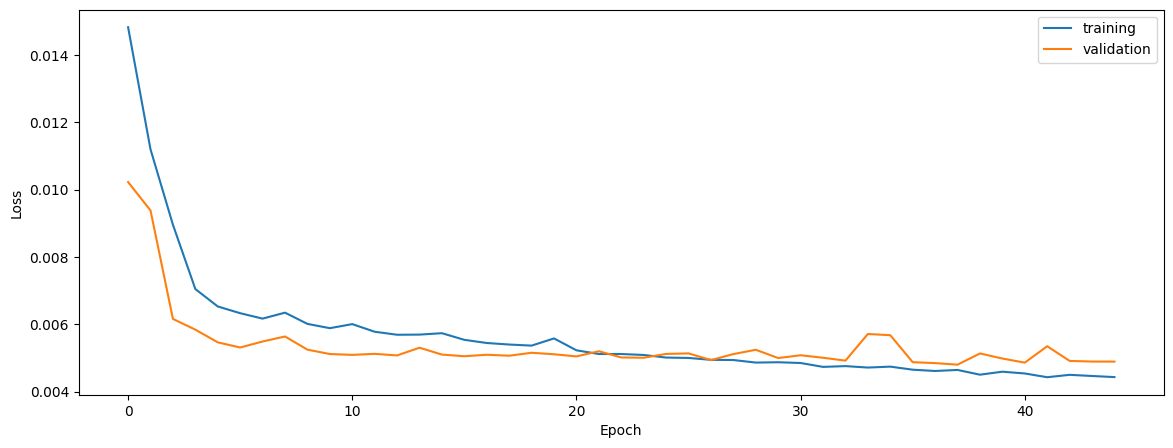

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7801688482322809
0.729129060261823
0.6977928609774111


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7801688482322809
0.729129060261823
0.6977928609774111


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7872109415722771
0.7281658121078265
0.7012103725389212


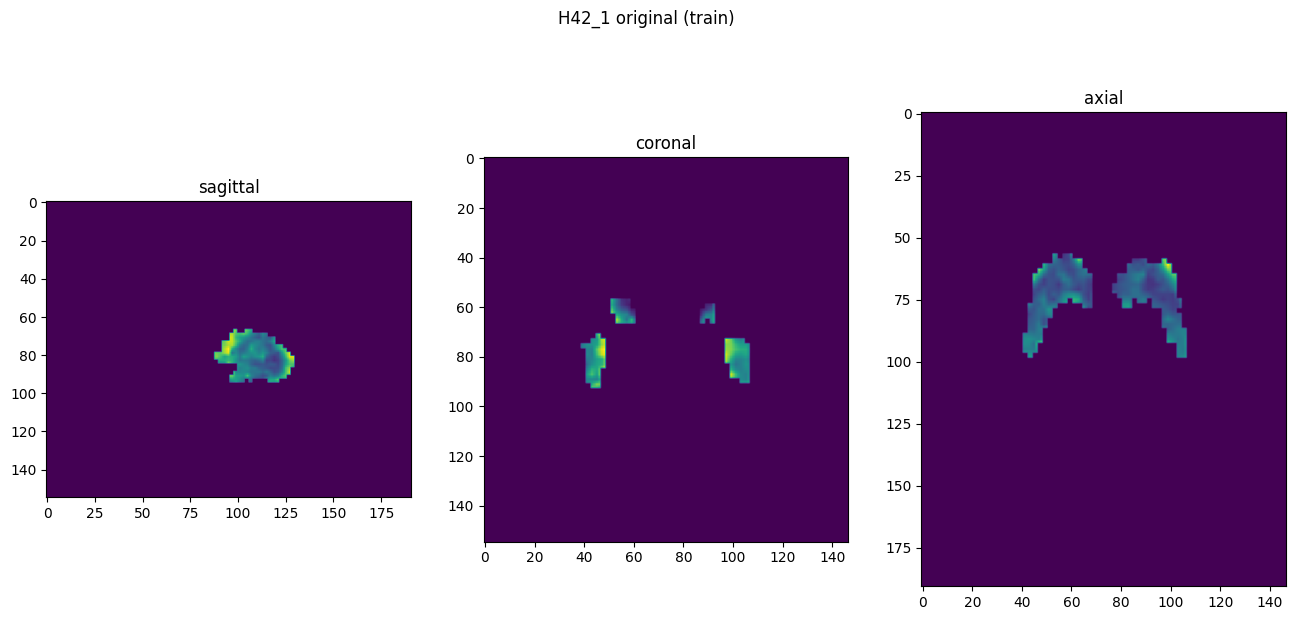

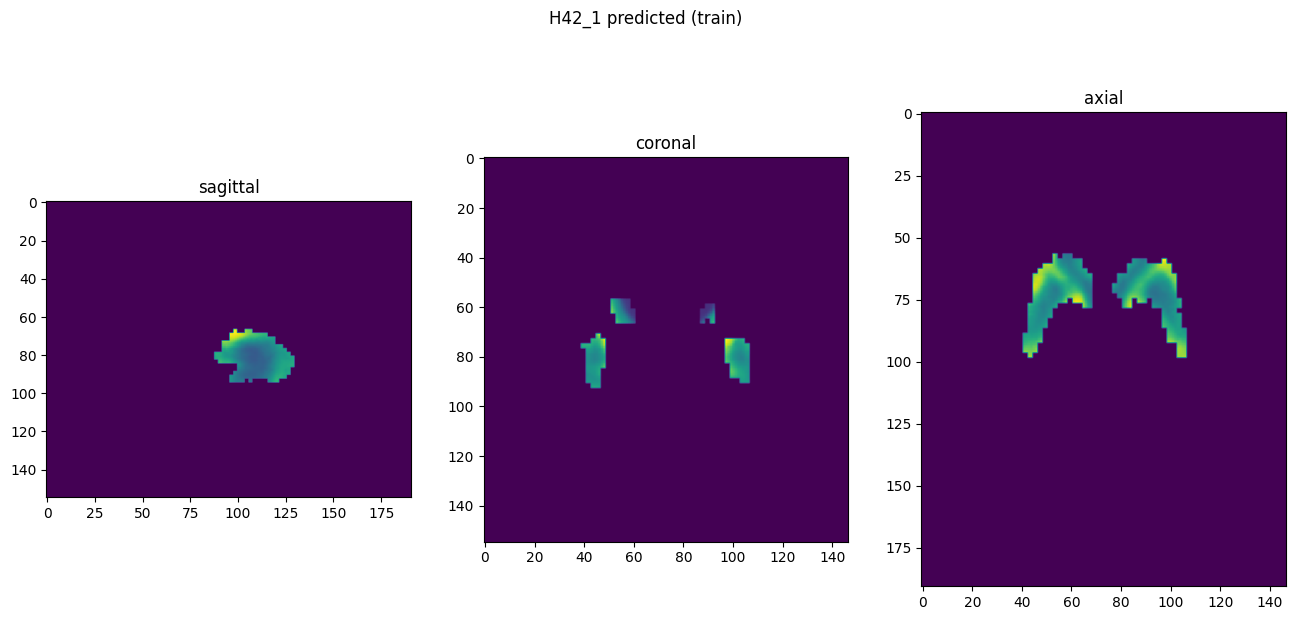

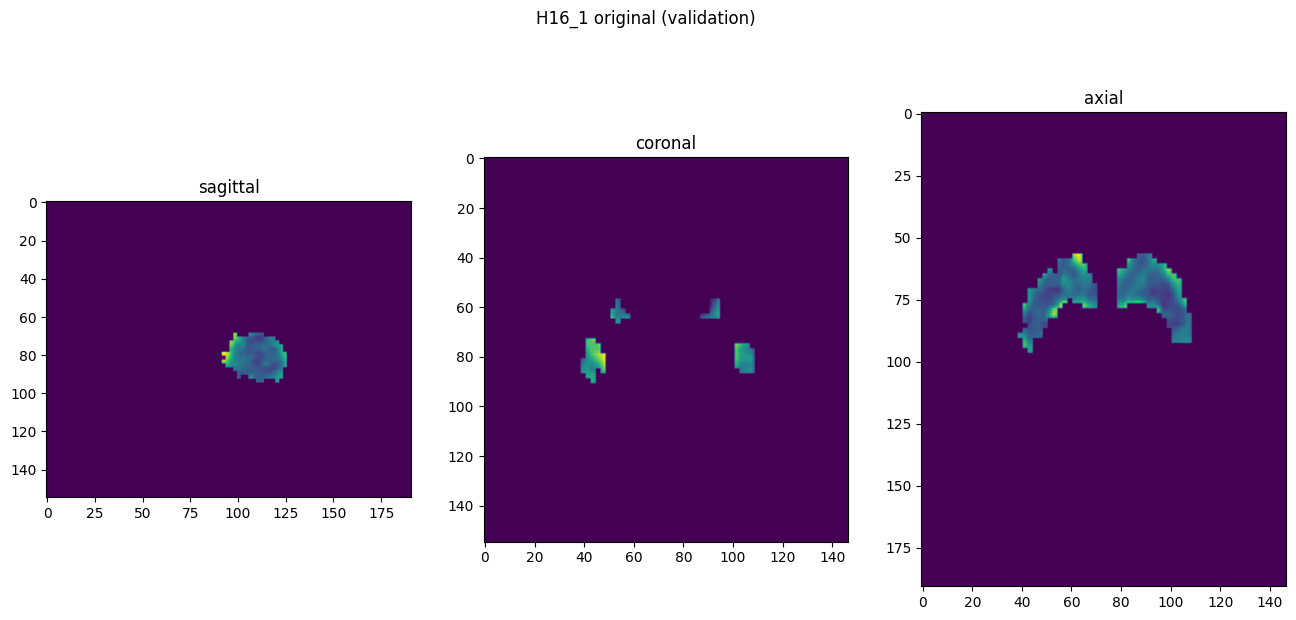

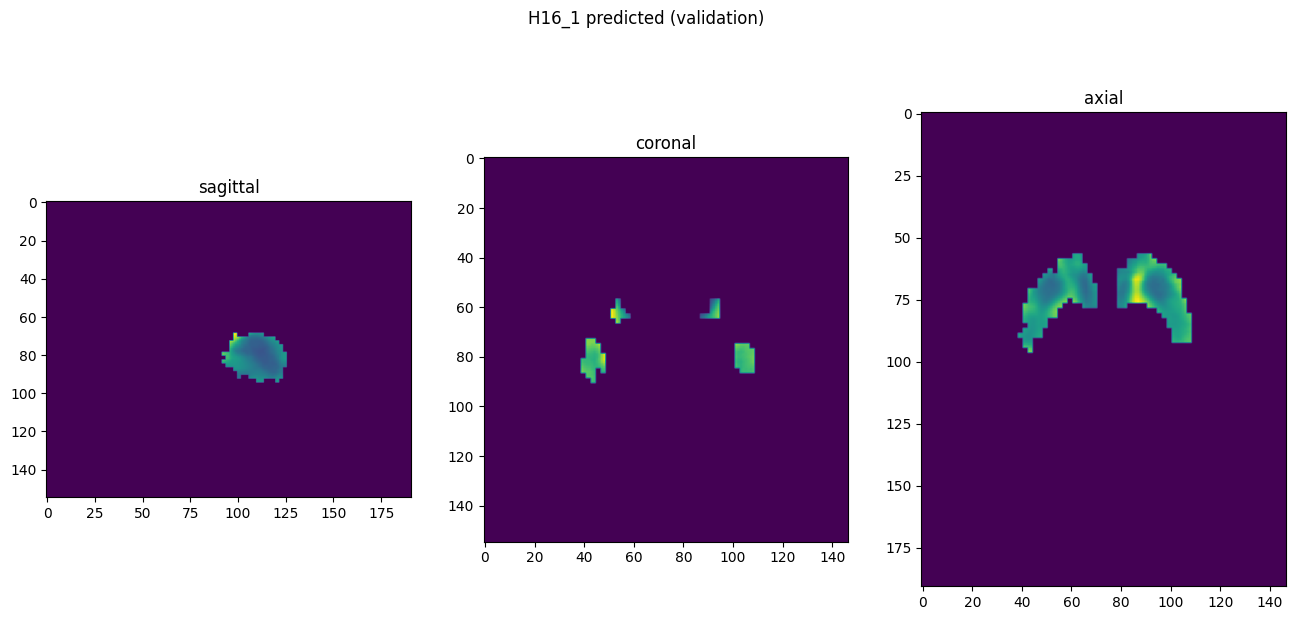

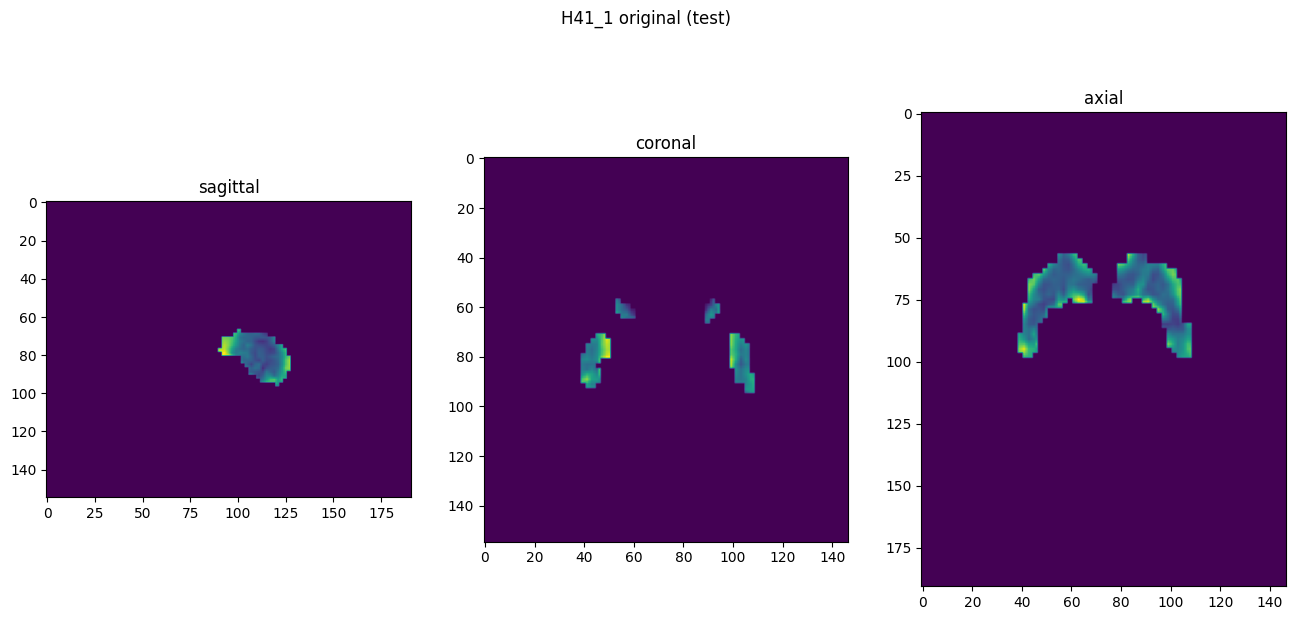

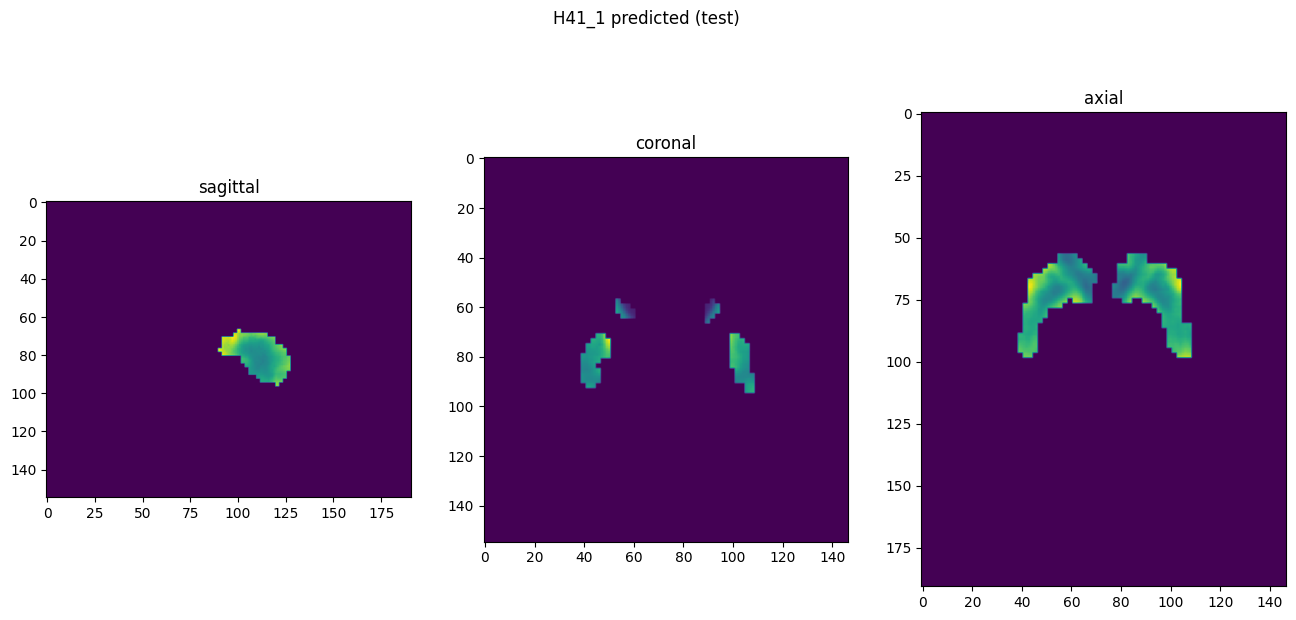

In [10]:
showResults(model, gen, threshold=None, background=False)